In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath , groutine

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
FWHM = 50 # (um)

my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=15.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ---------------------------------------------------------------------------------------------------------- 
grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(0.5)
grating_list[0].set_b(0.5)
grating_list[1].set_a(0.5)
grating_list[1].set_b(0.5)

dtheta = np.arctan(grating_list[0].base_wave_vector[1] / my_pulse.klen0)  # This is the deviation angle.


# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 10e-6

d1 = 0.
d2 = 15.5e-6
d3 = 15.5e-6
d4 = 0.

# Get crystal angles
eta_b1 = np.zeros(8, dtype=np.float64)
theta_b1 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg + d2,
                     3 * np.pi / 2. + bragg + d2,
                     np.pi / 2. + bragg + d3,
                     3 * np.pi / 2. + bragg + d3,
                     3 * np.pi / 2. - bragg + d4,
                     np.pi / 2. - bragg + d4])

rho_b1 = theta_b1 + np.pi

asy_angle = np.deg2rad(5)
rho_b1[1] += asy_angle
rho_b1[2] -= asy_angle
rho_b1[5] -= asy_angle
rho_b1[6] += asy_angle

tau_b1 = np.zeros(8)


# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=8,
                                           hlen=np.array([h_length, ] * 8),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_fix = [5e6 - 1e5, 1.1e5, 6.5e5, 1.12e5, 6e6, 1e6]
path_list_var = [5e6, 1e4, 5e4, 1e4, 20e4, 10e4, 10e4, 10.2e4, 6e6, 1e6]
delay_time = 20

# Arrange the crystals

In [3]:
# ---------------------------------------------------------------------------
#                  Adjust the position of the crystals
# ---------------------------------------------------------------------------

(fix_branch_path,
 kout_fixed,
 intersect_fixed,
 var_branch_path,
 kout_var,
 intersect_var) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_fix,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_var,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=my_pulse.k0)

# -----------------------------------------------------------------------------
#                 Update the crystals
# -----------------------------------------------------------------------------
crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                              surface_points=np.copy(intersect_var[1:-2]))
crystal_list_2 = lclsutil.update_crystal_list(crystal_list_2,
                                              surface_points=np.copy(intersect_fixed[1:-2]))
grating_list[0].set_surface_point(np.copy(intersect_fixed[0]))
grating_list[1].set_surface_point(np.copy(intersect_fixed[-2]))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_fixed[-1]) 
total_path = pre_length + np.sum(fix_branch_path)

print("The total propagation length is {:.2f}m.".format(total_path / 1e6))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(my_pulse,
 observation,
 [crystal_list_1, 
  crystal_list_2,
  grating_list]
) = lclsutil.get_output_frame(displacement=-np.copy(intersect_fixed[-1]),
                              observe=observation,
                              pulse=my_pulse,
                              crystal_lists = [crystal_list_1, 
                                               crystal_list_2,
                                               grating_list])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 250
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                          number_y=number_y,
                                                          number_z=number_z,
                                                          delta_e_x=1e-50,
                                                          delta_e_y=6e-5,
                                                          delta_e_z=1e-3 / util.c)
kz_grid += my_pulse.klen0

# Apply fft shift
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.zeros(1, np.float64)
number_y = 1
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

The total propagation length is 11.90m.


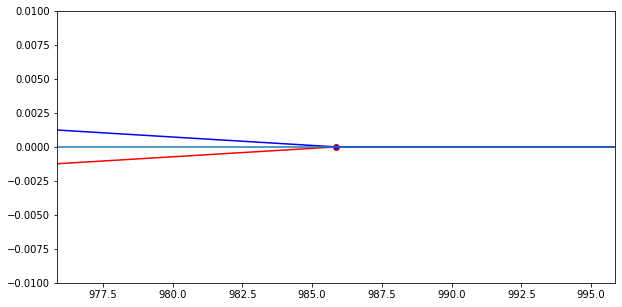

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_var[:,2]/1e4, intersect_var[:,1]/1e4,'ro-')
axes.plot(intersect_fixed[:,2]/1e4, intersect_fixed[:,1]/1e4,'b*-')

axes.plot([0, 1300], [0,0])
axes.set_xlim([intersect_fixed[-2,2]/1e4 - 10, intersect_fixed[-2,2]/1e4 + 10])
axes.set_ylim([-0.01, 0.01])
#axes.set_aspect('equal', 'datalim')

plt.show()

In [5]:
# Set the range of the index to save
z_idx_range = number_z
num1 = number_z-200
num2 = 200
d_num = 512

# -------------------------------------------------------------
#            Get Field for variable branch
# -------------------------------------------------------------
tic = time.time()

(result_3d_var,
 result_2d_var,
 check_var
) = groutine.get_split_delay_single_branch_field(grating_pair = grating_list,
                                                 channel_cuts = crystal_list_1,
                                                 total_path = total_path, 
                                                 observation = observation,
                                                 my_pulse = my_pulse,
                                                 kx_grid = kx_grid,
                                                 ky_grid = ky_grid,
                                                 kz_grid = kz_grid,
                                                 pulse_delay_time = 0.,
                                                 pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                                 grating_orders = [1., -1.],
                                                 number_x = number_x,
                                                 number_y = number_y,
                                                 number_z = number_z,
                                                 z_idx_range = z_idx_range,
                                                 num1 = num1,
                                                 num2 = num2, 
                                                 d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.05 seconds to prepare the variables.
It takes 0.39 seconds to get the field for branch 1.


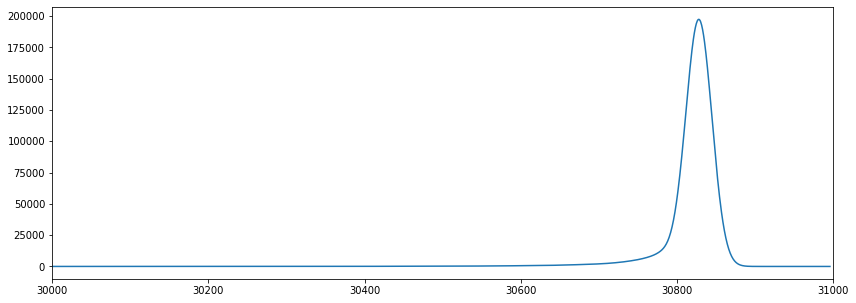

In [6]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(14)

axes.plot(axis_info["z_time_idx"], np.abs(result_3d_var['efield_3d'][0,0,:,1]))
axes.set_xlim([30000, 31000])
plt.show()

In [7]:
# -------------------------------------------------------------
#            Get Field for fixed-dealy branch
# -------------------------------------------------------------
tic = time.time()

(result_3d_fix,
 result_2d_fix,
 check_fix
) = groutine.get_split_delay_single_branch_field(grating_pair = grating_list,
                                                 channel_cuts = crystal_list_2,
                                                 total_path = total_path, 
                                                 observation = observation,
                                                 my_pulse = my_pulse,
                                                 kx_grid = kx_grid,
                                                 ky_grid = ky_grid,
                                                 kz_grid = kz_grid,
                                                 pulse_delay_time = 0.,
                                                 pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                                 grating_orders = [-1., 1.],
                                                 number_x = number_x,
                                                 number_y = number_y,
                                                 number_z = number_z,
                                                 z_idx_range = z_idx_range,
                                                 num1 = num1,
                                                 num2 = num2, 
                                                 d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.05 seconds to prepare the variables.
It takes 0.13 seconds to get the field for branch 1.


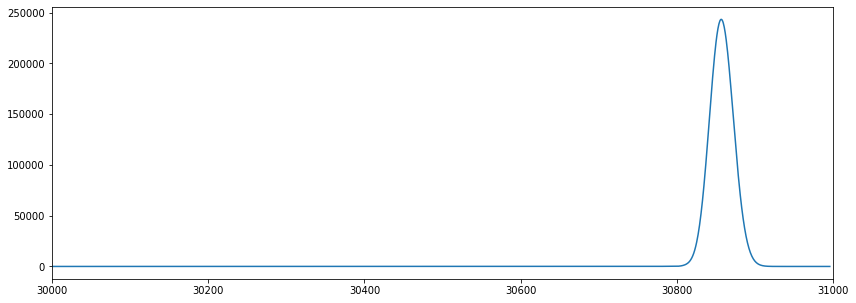

In [8]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(14)

axes.plot(axis_info["z_time_idx"], np.abs(result_3d_fix['efield_3d'][0,0,:,1]))
axes.set_xlim([30000, 31000])
plt.show()

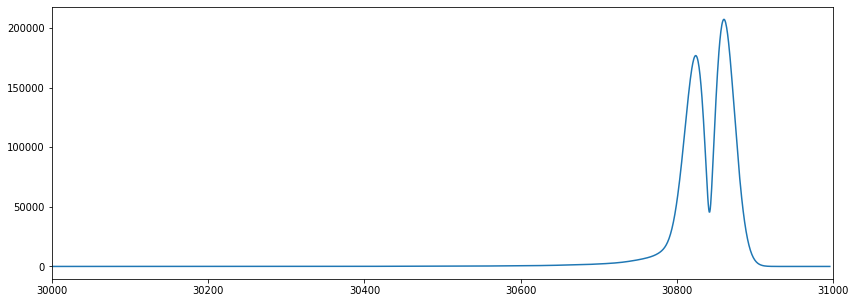

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(14)

axes.plot(axis_info["z_time_idx"], np.abs(result_3d_fix['efield_3d'][0,0,:,1] + 
                                         result_3d_var['efield_3d'][0,0,:,1]))
axes.set_xlim([30000, 31000])
plt.show()

# Calculate the energy transmission efficiency

In [10]:
# Calculate the incident total energy
energy_in = 8 * np.pi ** 2 * (FWHM /2. / np.sqrt(np.log(2))) ** 2

# Calculate the energy of the branch with variable delay time
energy_var = np.sum(np.square(np.abs(result_3d_var['efield_spec_3d']))) * (kz_grid[1] - kz_grid[0])

# Calculate the energy of the branch with fixed delay time
energy_fix = np.sum(np.square(np.abs(result_3d_fix['efield_spec_3d']))) * (kz_grid[1] - kz_grid[0])

print("The efficiency of the branch with a variable delay time is {:.2e}.".format(energy_var / energy_in))
print("The efficiency of the branch with a fixed delay time is {:.2e}.".format(energy_fix / energy_in))
print("The efficiency difference between the two branch is {:.2e}.".format(energy_var / energy_fix))

The efficiency of the branch with a variable delay time is 9.00e-02.
The efficiency of the branch with a fixed delay time is 1.22e-01.
The efficiency difference between the two branch is 7.38e-01.
